In [9]:
import pandas as pd

I first try to see if I can find any riding pattern from the data. The following code was executed in the terminal to extract the start hour and end hour of the trips during the weekdays. I put a filter on the weekdays and extracted the hour + minute of the start and end dates of trips. The objective is to look at the histogram of riding hours to extract riding patterns during weekdays.

```
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT trip_id, 
EXTRACT(HOUR FROM start_date)+EXTRACT(MINUTE FROM start_date)/60 AS start_hour, 
EXTRACT(HOUR FROM end_date)+EXTRACT(MINUTE FROM end_date)/60 AS end_hour
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE (EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)) and (EXTRACT(DAYOFWEEK FROM end_date) NOT IN (1, 7))
order by start_hour' > result.csv
```

In [75]:
# import the CSV file
pop_trips = pd.read_csv('result.csv')

Text(0.5, 1.0, 'histogram of trip start hours in weekdays')

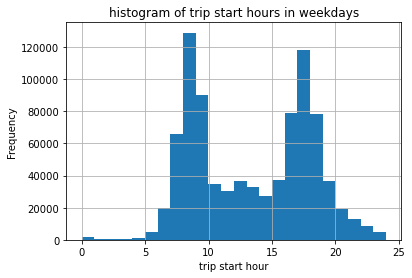

In [76]:
# Histogram plot of the start hours of trips in weekdays
ax = pop_trips.start_hour.hist(bins = 24)
ax.set_ylabel("Frequency") 
ax.set_xlabel("trip start hour") 
ax.set_title("histogram of trip start hours in weekdays")

From the histogram of the start hours of trips during weekdays, there is a clear biking pattern that peaks in the
morning between 8-10 am and also in the evening from 16-18 which is consistent with start and end worh hours. A similar pattern exists for the end hours of the trip as shown in the histogram plot below. 

Text(0.5, 1.0, 'histogram of trip end hours in weekdays')

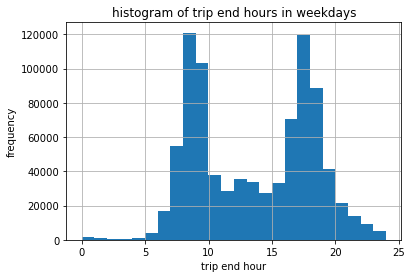

In [12]:
# Histogram plot of the end hours of trips in weekdays
ax = pop_trips.end_hour.hist(bins = 24)
ax.set_ylabel("frequency") 
ax.set_xlabel("trip end hour")
ax.set_title("histogram of trip end hours in weekdays")

Now I would like to take a look at the trip durations for those trips within the weekdays. I use the following query in the Terminal. It looks like 97% of the trips are below 30 minutes. This is another indication that majority of people use bikes to get to the Caltrain stations or from Caltrain stations to work on a daily basis.  

```
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT trip_id, 
duration_sec/60 trip_duration_min
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE (EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)) and (EXTRACT(DAYOFWEEK FROM end_date) NOT IN (1, 7))
order by trip_duration_min desc' > result1.csv
```

In [67]:
# Trips duration in weekdays
trip_duration = pd.read_csv('result1.csv')
print("percentage of trips being less than 30 min:")
100*len(trip_duration.trip_duration_min[trip_duration.trip_duration_min <= 30])/len(trip_duration.trip_duration_min)

percentage of trips being less than 30 min:


96.97708227912736

Now we want to see if we have any supply shortage during peak hours. The following query groups the hours when the `bikes_availale` is zero and counts the number of zero bike availability events within weekdays. 

In [35]:
%%bigquery zero_bike
SELECT hour, count(hour) as zero_bike_hour_freq
from (
SELECT EXTRACT(HOUR FROM time) AS hour 
FROM `bigquery-public-data.san_francisco.bikeshare_status` 
WHERE (EXTRACT(DAYOFWEEK FROM time) NOT IN (1, 7)) and bikes_available = 0
)
group by hour 
order by zero_bike_hour_freq desc


As the result shows below, the zero bike availibility frequency peaks during peak riding hours e. g. hours 9-10 and 18-19.

In [36]:
zero_bike.head(5)

,hour,zero_bike_hour_freq
0,18,93322
1,9,71380
2,17,66034
3,10,47665
4,19,47480


The following figure shows hours in terms of the number of zero bike availibility events for weekdays. It is consistent with the peak riding hours. In other words, the zero bike availibility events peak during high demand hours especially 9 AM and 18 PM.

<AxesSubplot:title={'center':'number of zero bike events in weekdays'}, xlabel='hour', ylabel='zero_bike_hour_freq'>

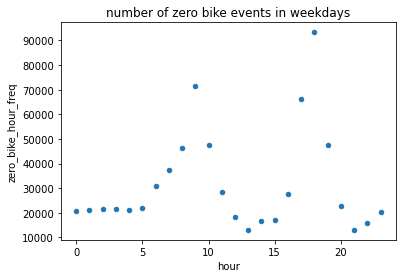

In [37]:
zero_bike.plot(x='hour', y='zero_bike_hour_freq', kind='scatter', title='number of zero bike events in weekdays')

This is clearly a daily pattern of people who go to work in the morning and come back in the evening. The following query shows that San Francisco Caltrain is among the top 10 most favorite stations during peak hours. It looks like the bike users are motly subscribers so they have either annual or 30-say membership. So one recommendation here is to promote subscribers with adding off-peak hour ride discount features. We oserved that the zero bike availibility events peak during peak hours so if the company can encourage the subscribers to ride during off-peak hours like 10 AM -15 PM or after 19 PM, we are going to see significat reduction in the number of zero availability events which means increased ridership.

In [77]:
%%bigquery pop_stations
SELECT start_hour, start_station_name, count(trip_id) trip_freq, subscriber_type
from (
SELECT trip_id, start_station_name, EXTRACT(HOUR FROM start_date) AS start_hour, subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE (EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)) and (EXTRACT(HOUR FROM start_date) IN (8,9,10,16,17,18))
)
group by start_hour, start_station_name, subscriber_type
order by trip_freq desc 

In [78]:
pop_stations.head(10)

,start_hour,start_station_name,trip_freq,subscriber_type
0,8,San Francisco Caltrain (Townsend at 4th),16994,Subscriber
1,8,San Francisco Caltrain 2 (330 Townsend),14817,Subscriber
2,8,Harry Bridges Plaza (Ferry Building),11456,Subscriber
3,9,San Francisco Caltrain 2 (330 Townsend),9133,Subscriber
4,8,Temporary Transbay Terminal (Howard at Beale),8647,Subscriber
5,9,San Francisco Caltrain (Townsend at 4th),8391,Subscriber
6,8,Steuart at Market,6847,Subscriber
7,18,San Francisco Caltrain (Townsend at 4th),5775,Subscriber
8,17,2nd at Townsend,5716,Subscriber
9,17,Townsend at 7th,5716,Subscriber


The following filter shows that some bike users during peak hours are marked as "Customer" with a day pass or 3-day pass. 

In [34]:
pop_stations[pop_stations['subscriber_type']=="Customer"].head(5)

,start_hour,start_station_name,trip_freq,subscriber_type
151,16,Embarcadero at Sansome,988,Customer
172,17,Embarcadero at Sansome,797,Customer
195,18,Embarcadero at Sansome,580,Customer
200,17,Harry Bridges Plaza (Ferry Building),557,Customer
201,16,Harry Bridges Plaza (Ferry Building),542,Customer


As shown earlier, the number of trips "Customer" type bike users go is much less than that for "Subscriber" members. So we could add a feature that during peak hours in the case of lack of bike availabiity, the subscriber members have priority over the "Customer" users. This policy could encourage the "Customer" users to become a long-term subscribers which increases the ridership. Below is the comparison of the number of trips for Customers v.s Subscriber. 

```
Row	     subscriber_type	  number_of_trips	
1            Customer               136809
2            Subscriber             846839
```

Now I am looking at stations that generate the highest number of zero bike availability events in weekdays during high demand hours. Spoting those stations helps with identifying supply shortages and recomendations to increase ridership. The following query lists the top 5 stations which create the highest number of zero bike events during peak hours. One strategy to increase the ridership could be to have more bikes available in those stations though expanding the number of docks and bikes. 

In [71]:
%%bigquery
SELECT hour, name, count(hour) as zero_bike_hour_freq
from (
SELECT EXTRACT(HOUR FROM time) AS hour, station.name
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` station on status.station_id = station.station_id
WHERE (EXTRACT(DAYOFWEEK FROM time) NOT IN (1, 7)) and bikes_available = 0
)
group by hour, name
order by zero_bike_hour_freq desc
limit 10


,hour,name,zero_bike_hour_freq
0,9,San Francisco Caltrain (Townsend at 4th),11128
1,18,Broadway St at Battery St,10062
2,18,Embarcadero at Vallejo,7933
3,9,Temporary Transbay Terminal (Howard at Beale),7677
4,18,Commercial at Montgomery,7619
5,9,Grant Avenue at Columbus Avenue,6771
6,9,Embarcadero at Bryant,6530
7,10,San Francisco Caltrain (Townsend at 4th),6064
8,18,2nd at Folsom,6032
9,18,2nd at South Park,5903


Next I am going to check what stations have available bikes near those with zero bike availabiliy during weekdays. As stated earlier, there is a opportunity here to balance out the supply-demand at those stations which create high number of supply shortage. In the following query, I am going to explore if there are any staions with good amount of available bikes around those stations with zero bike availibility during peak hours. The following query shows the top ten stations with the most available bikes during peak hours. There is an opportunity here to increase the ridership. For example, Japantown with the highest numbber of available bikes during peak hours is only 6.5 miles away from San Francisco Caltrain station which has the highest number of zero bike availability events. So they could either have a shuttle bus to take bikers from the San Francisco Caltrain station to the Japantown station or they could bring move available bikes from the Japantown station to the San Francisco Caltrain station and this will lower the  number of zero available bike events and increase the ridership and company's profit. Temporary Transbay Terminal is another station that creates high number of bike unavailability and it is about 2.3 miles away from Japantown. In case of shuttle bus, the bikers can be encouraged to use the shuttle by promoting the subscribers with some discount.  

In [72]:
%%bigquery
SELECT hour, name, count(hour) as bike_available_sum
from (
SELECT EXTRACT(HOUR FROM time) AS hour, station.name
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` station on status.station_id = station.station_id
WHERE (EXTRACT(DAYOFWEEK FROM time) NOT IN (1, 7)) and (EXTRACT(HOUR FROM time) IN (9))
)
group by hour, name
order by bike_available_sum desc
limit 10

,hour,name,bike_available_sum
0,9,Japantown,46339
1,9,San Pedro Square,46339
2,9,MLK Library,46339
3,9,San Jose City Hall,46339
4,9,Paseo de San Antonio,46339
5,9,Adobe on Almaden,46339
6,9,San Salvador at 1st,46339
7,9,Santa Clara at Almaden,46339
8,9,San Jose Diridon Caltrain Station,46339
9,9,San Jose Civic Center,46339


* What are the 5 most popular trips that you would call "commuter trips"?

Next, with  a new definition of "commuter trips", I am going to find the top five most popular commuter trips. Based on the daily riding pattern, I define a commuter trip as a trip from A to B to C. The reason is people seem to go from a station close to Caltrain to a station close to work in the morning and then in the evening they go back from the same direction. So here we are looking for trips from A - B and B - C with the highest number of `trip_id`. To achieve this, I join two aggregated 'trip' tables on the condition that the end_station of the first 'trip' table (called trip 1) will be the same as the start_station of the second 'trip' table (called trip 2). And finally I get the start_station and end_station of trip 1 and the end_station of trip 2 and the total comuter trip count would be (count of trip1 + count trip2)/2 sorted. The following table shows the top 5 most popular commuter trips.

In [74]:
%%bigquery
select trip1.start_station_name, 
trip1.end_station_name, 
trip2.end_station_name, 
(trip1.trip_number + trip2.trip_number)/2 AS commuter_trips_count
from  
(SELECT  
 start_station_name, 
 end_station_name, 
 count(trip_id) AS trip_number
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
group by start_station_name, end_station_name) trip1 
join 
(SELECT
 start_station_name, 
 end_station_name, 
 count(trip_id) AS trip_number
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
group by start_station_name, end_station_name) trip2
on trip1.end_station_name = trip2.start_station_name
--where EXTRACT(DAYOFWEEK FROM trip1.start_date) NOT IN (1, 7)
order by commuter_trips desc
limit 5

,start_station_name,end_station_name,end_station_name_1,commuter_trips
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,8385.0
1,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,Steuart at Market,8012.0
2,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,7682.5
3,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),7672.0
4,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,7672.0


Lastly, I am going to test a similar analysis using the riding data in weekends. The weekends are filterd by Extract() function compared against Saturday and Sunday. As shown below from the histogram, the bike trips peak in the after noon, however as shown in the scatter plot, the number of zero bike events generated for the weekends is significantly lower than that for weekdays. 

In [ ]:
%%bigquery trip_weekend
SELECT trip_id, 
EXTRACT(HOUR FROM start_date)+EXTRACT(MINUTE FROM start_date)/60 AS start_hour, 
EXTRACT(HOUR FROM end_date)+EXTRACT(MINUTE FROM end_date)/60 AS end_hour
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE (EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7)) and (EXTRACT(DAYOFWEEK FROM end_date) IN (1, 7))

Text(0.5, 1.0, 'histogram of trip start hours in weekends')

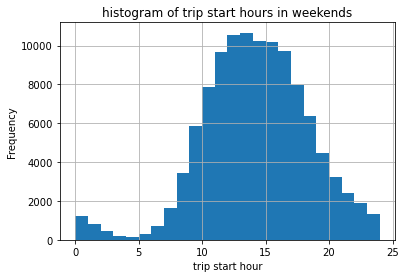

In [6]:
# Histogram plot of the start hours of trips in weekends
ax = trip_weekend.start_hour.hist(bins = 24)
ax.set_ylabel("Frequency") 
ax.set_xlabel("trip start hour")
ax.set_title("histogram of trip start hours in weekends")

In [3]:
%%bigquery zero_bike_weekend
SELECT hour, count(hour) as zero_bike_hour_freq
from (
SELECT EXTRACT(HOUR FROM time) AS hour, 
FROM `bigquery-public-data.san_francisco.bikeshare_status` 
WHERE (EXTRACT(DAYOFWEEK FROM time) IN (1, 7)) and bikes_available = 0
)
group by hour 
order by zero_bike_hour_freq desc

<AxesSubplot:title={'center':'number of zero bike events in weekends'}, xlabel='hour', ylabel='zero_bike_hour_freq'>

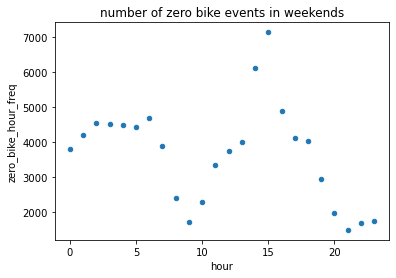

In [21]:
zero_bike_weekend.plot(x='hour', y='zero_bike_hour_freq', kind='scatter', title='number of zero bike events in weekends')

A similar recomendation could apply here to add a discount promotion to subscriber to move the riding load from peak hours (15-17) to either evening after 19 PM or around 9-10 AM.